Hamiltonian to implement:
$$
\mathcal H(\mathbf k) = \left(
    \begin{array}{cc}
      h(\mathbf k) & 0 \\
      0 & h^{\dagger}(-\mathbf k) 
    \end{array}
\right)
$$
$$
h(\mathbf k) = \epsilon(k) + \mathbf d (\mathbf k)\mathbf\sigma \textrm{, } \, \mathbf k = (k_x, k_y)
$$
$$
\mathbf d(\mathbf k ) = (Ak_x, Ak_y, M-Bk^2) \textrm{; } \, \epsilon(k) = C-Dk^2
$$

$$
= \left(
    \begin{array}{cc}
        (C-Dk^2)\sigma_0 + Ak_x\sigma_x + Ak_y\sigma_y + (M-Bk^2)\sigma_z & 0 \\
        0 & (C-Dk^2)\sigma_0 - Ak_x\sigma_x - Ak_y\sigma_y + (M-Bk^2)\sigma_z
    \end{array}
    \right)
$$


$$
=(C-Dk^2)\left(
\begin{array}{cc}
\sigma_0 & 0 \\
0 & \sigma_0
\end{array}
\right)
+ (M-Bk^2)
\left(
\begin{array}{cc}
\sigma_z & 0 \\
0 & \sigma_z
\end{array}
\right)
+ Ak_x 
\left(
\begin{array}{cc}
\sigma_x & 0 \\
0 & -\sigma_x
\end{array}
\right)
+ Ak_y
\left(
\begin{array}{cc}
\sigma_y & 0 \\
0 & -\sigma_y
\end{array}
\right)
$$

# Plot probability and spin densities

In [2]:
import kwant
import kwant.continuum
import scipy.sparse.linalg
import scipy.linalg
import numpy as np

# For plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = True

s0 = np.eye(2)
sx = np.array([[0,1], [1,0]])
sy = np.array([[0, -1j],[1j, 0]])
sz = np.array([[1,0],[0,-1]])

A=3.65
B=-68.6
D=-51.1
M=-0.01
C=0

def qsh_system(a=20, L=2000, W=1000):
    hamiltonian_orig = """
       + C * identity(4) + M * kron(sigma_0, sigma_z)
       - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z)
       - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
       + A * k_x * kron(sigma_z, sigma_x)
       - A * k_y * kron(sigma_0, sigma_y)
       + V(x,y)*identity(4)
    """
    hamiltonian = """
    (C-D*(k_x**2+k_y**2))*identity(4)
    + (M-B*(k_x**2+k_y**2))*kron(sigma_0, sigma_z)
    + A*k_x*kron(sigma_z, sigma_x)
    + A*k_y*kron(sigma_z, sigma_y)
    + V(x,y)*identity(4)
    """
  
    template = kwant.continuum.discretize(hamiltonian, grid=a)

    def shape(site):
        (x, y) = site.pos
        return (0 <= y < W and 0 <= x < L)

    def lead_shape(site):
        (x, y) = site.pos
        return (0 <= y < W)

    syst = kwant.Builder()
    syst.fill(template, shape, (0, 0))

    lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
    lead.fill(template, lead_shape, (0, 0))

    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    syst = syst.finalized()
    return syst

def plot_prob_spin(W):
  print(W)
  def disorder(x,y):
    return np.random.uniform(-W/2, W/2)
  params = dict(A=A, B=B, D=D, M=M, C=C, V=disorder)
  syst = qsh_system()
  
  # get scattering wave functions at E=0
  wf = kwant.wave_function(syst, energy=0, params=params)
  
  # prepare density operators
  sigma_z = np.array([[1, 0], [0, -1]])
  prob_density = kwant.operator.Density(syst, np.eye(4))
  spin_density = kwant.operator.Density(syst, np.kron(sigma_z, np.eye(2)))
  
  # calculate expectation values and plot them
  wf_sqr = sum(prob_density(psi) for psi in wf(0))  # states from left lead
  rho_sz = sum(spin_density(psi) for psi in wf(0))  # states from left lead
  
  fig, ax = plt.subplots(figsize=(10,6), dpi=196)
  kwant.plotter.map(syst, rho_sz, ax=ax)
  ax.set_title('Spin density')
  fig.savefig("spin_dens_W={0}.png".format('dot'.join(str(W).split('.'))), dpi=196)
  
  fig, ax = plt.subplots(figsize=(10,6), dpi=196)
  kwant.plotter.map(syst, wf_sqr, ax=ax)
  ax.set_title('Probability density')
  fig.savefig("proba_dens_W={0}.png".format('dot'.join(str(W).split('.'))), dpi=196)
  return

def transmission_test(a=20, L=2000, W=1000, Wmax=0.2, npoints=20, Emax=0.5, nEpoints=1, plot=True):
  syst = qsh_system(a, L, W)
  
  W0s = np.logspace(np.log10(0.1), np.log10(Wmax), npoints) #np.logspace(0, np.log(5000)/np.log(10), 50)
  energies = np.linspace(0, 1.0, 5)

  Gs = {}
  for e in energies:
    Gs[repr(e)] = []
    for W0 in W0s:
      def disorder(x,y):
        return np.random.uniform(-W0/2, W0/2)
      params = dict(A=A, B=B, D=D, M=M, C=C, V=disorder)
      smat = kwant.smatrix(syst, energy=0, params=params)
      Gs[repr(e)].append(smat.transmission(1, 0))
  
  if plot==True:
    plt.figure(figsize=(8,6), dpi=196)
    for e in energies:
      plt.plot(W0s, Gs[repr(e)], '^-', mfc='none', label="$E={}$".format(np.round(e, 2)));
    plt.legend()
    plt.savefig("transmissions_wmax={0}.png".format('dot'.join(str(Wmax).split('.'))), dpi=196)
  return energies, W0s, Gs

In [ ]:
G = transmission_test(Wmax=500, npoints=60)

In [ ]:
GG = transmission_test(2, 25, 1.0, 4)

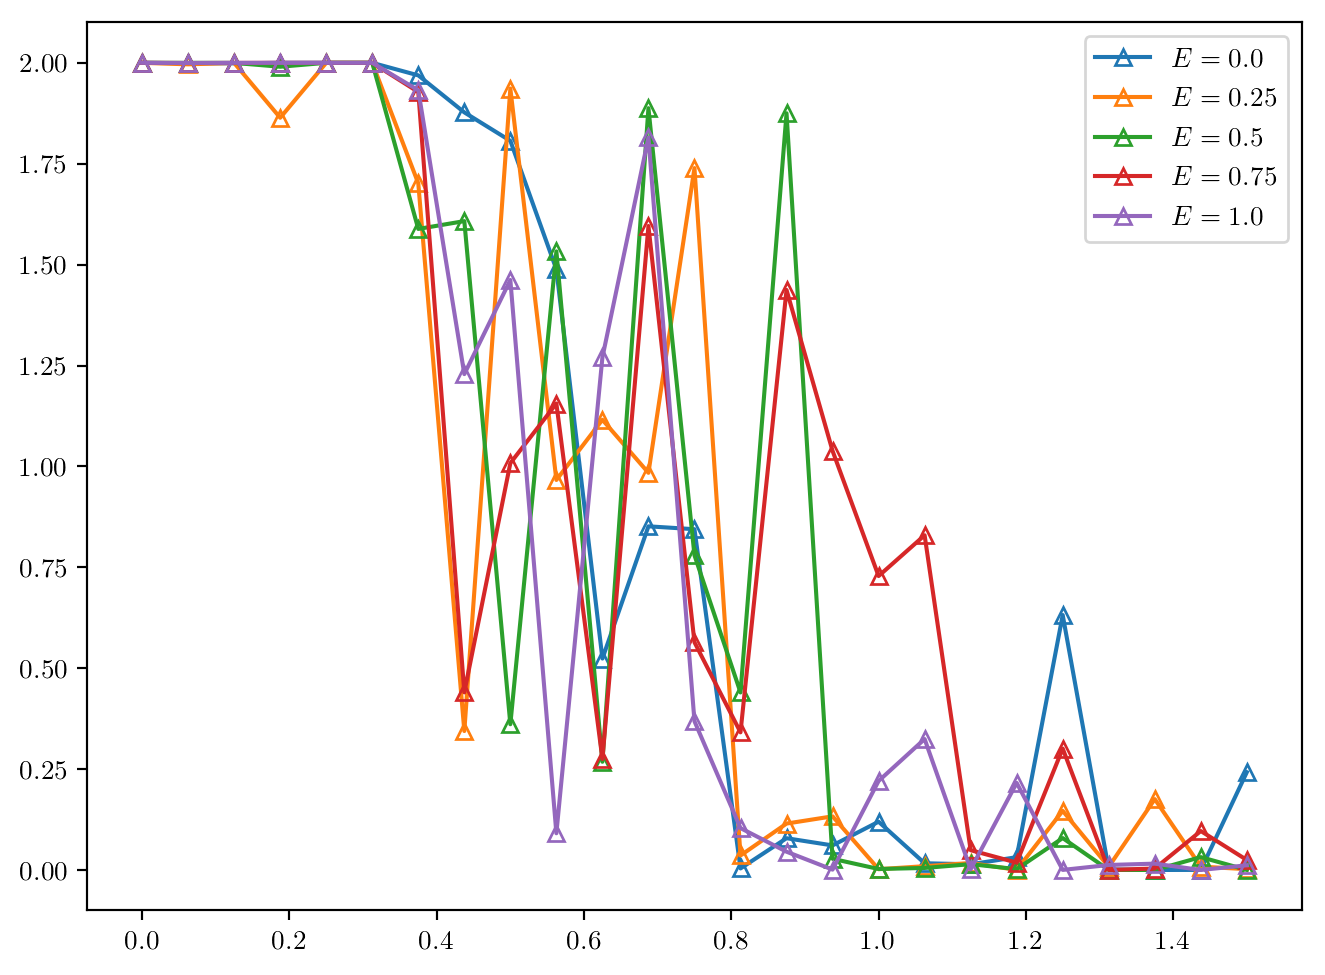

In [4]:
GGG = transmission_test(1.5, 25, 1.0, 4)

0


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: The plotted data contains 0.54% of values overflowing upper limit 1.73365e-14 and 1.80% of values underflowing lower limit -3.39816e-14 


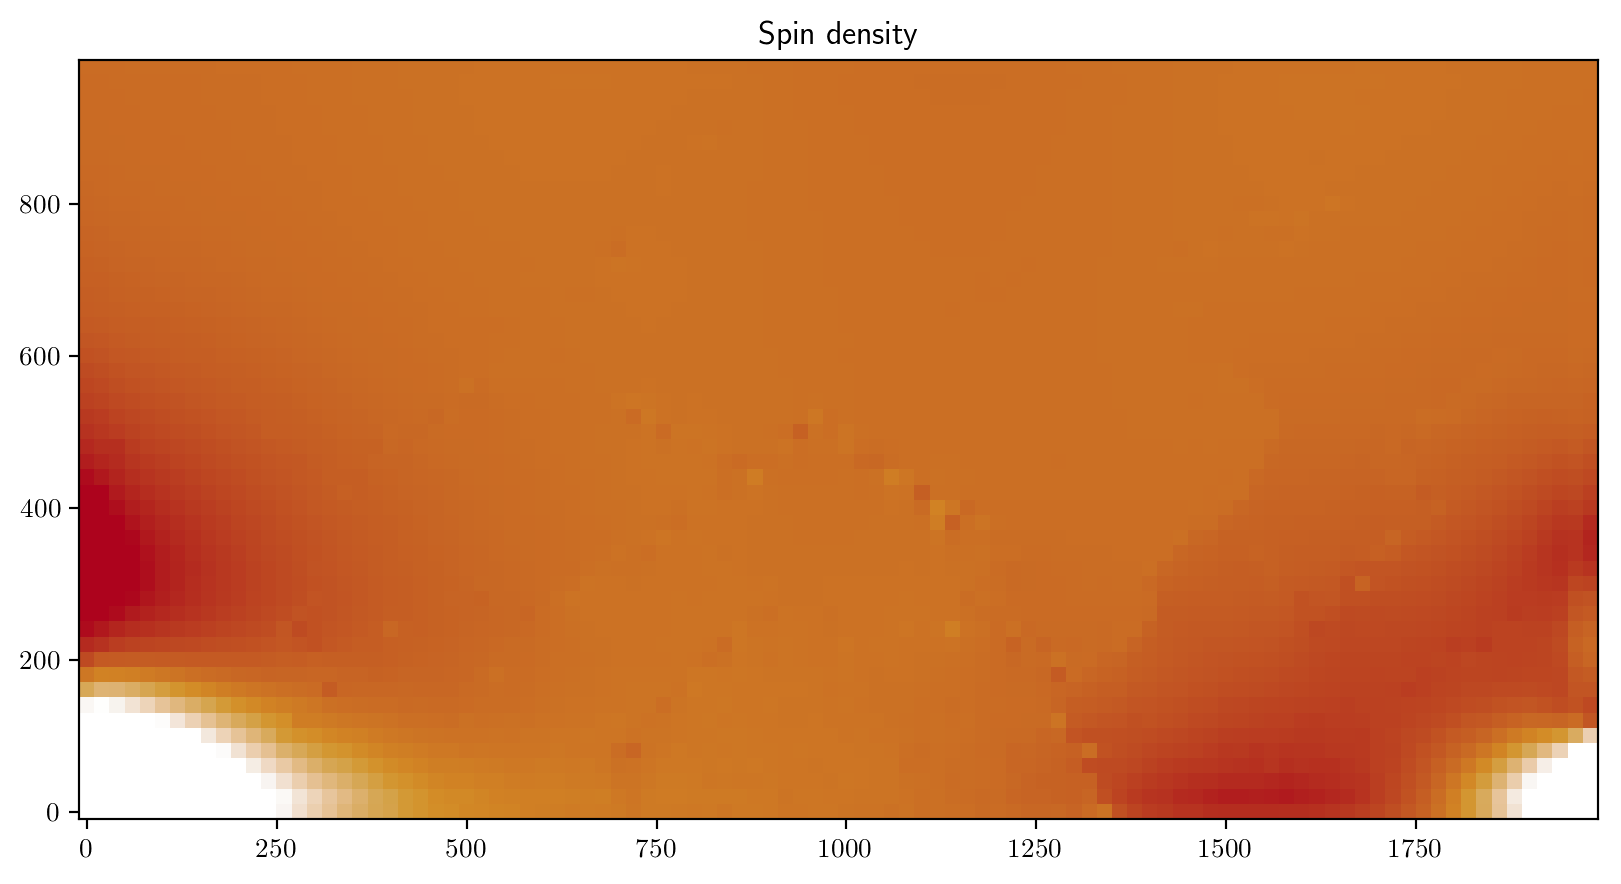

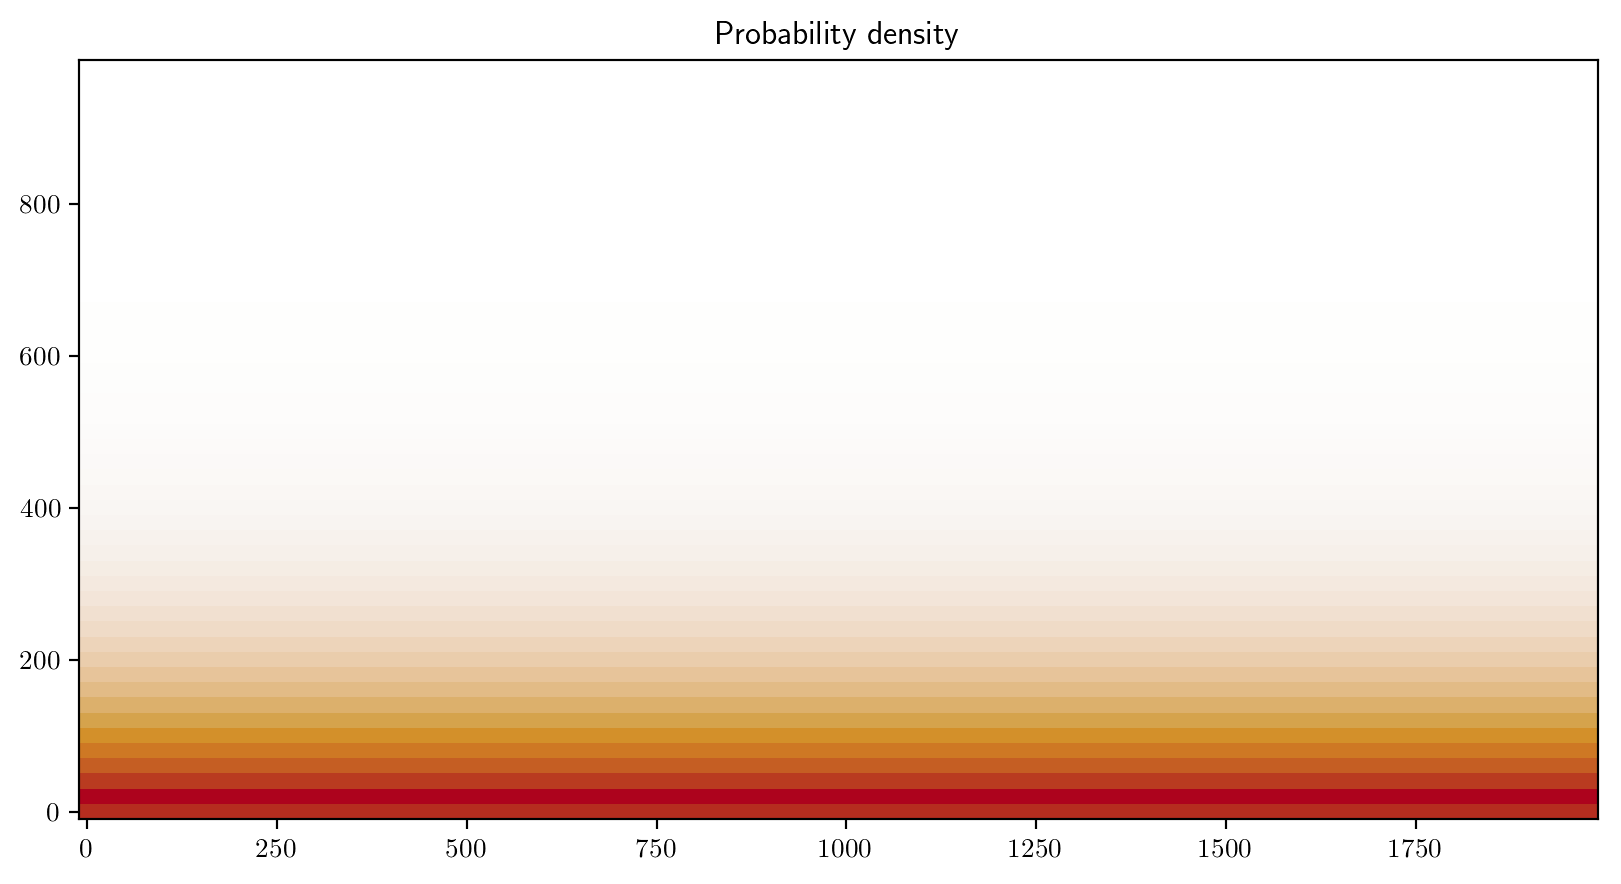

In [5]:
plot_prob_spin(0)

0.25


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: The plotted data contains 1.80% of values overflowing upper limit 4.84435e-13 and 0.16% of values underflowing lower limit -4.44921e-14 
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: The plotted data contains 1.78% of values overflowing upper limit 5.85916 


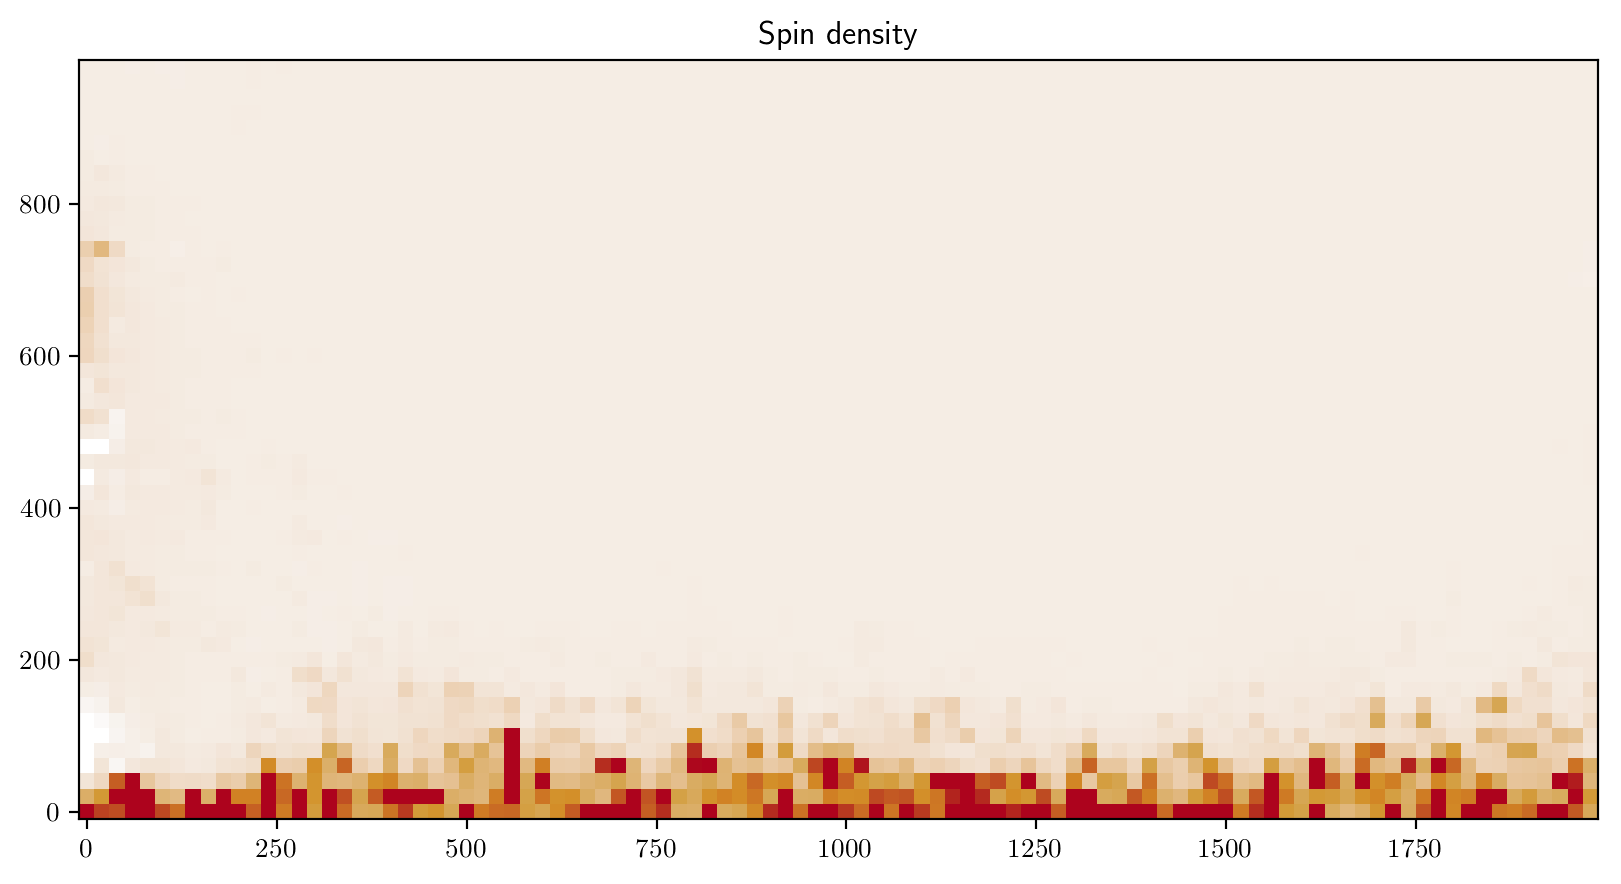

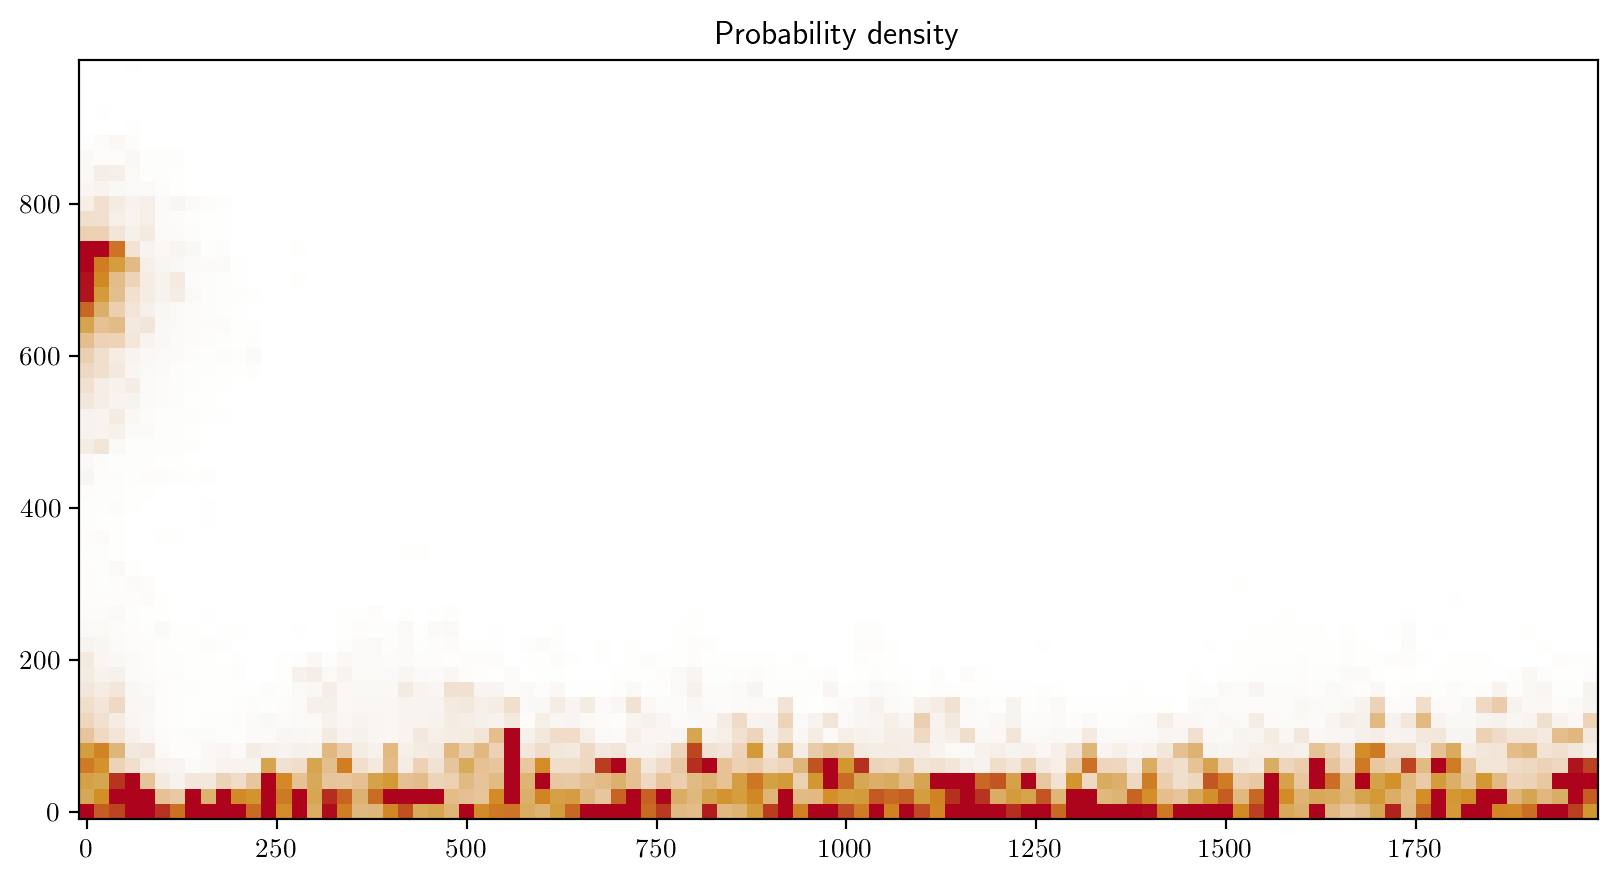

In [6]:
plot_prob_spin(.25)

0.5


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: The plotted data contains 0.28% of values overflowing upper limit 8.85157e-12 and 1.84% of values underflowing lower limit -8.90591e-11 
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: The plotted data contains 1.90% of values overflowing upper limit 127.499 


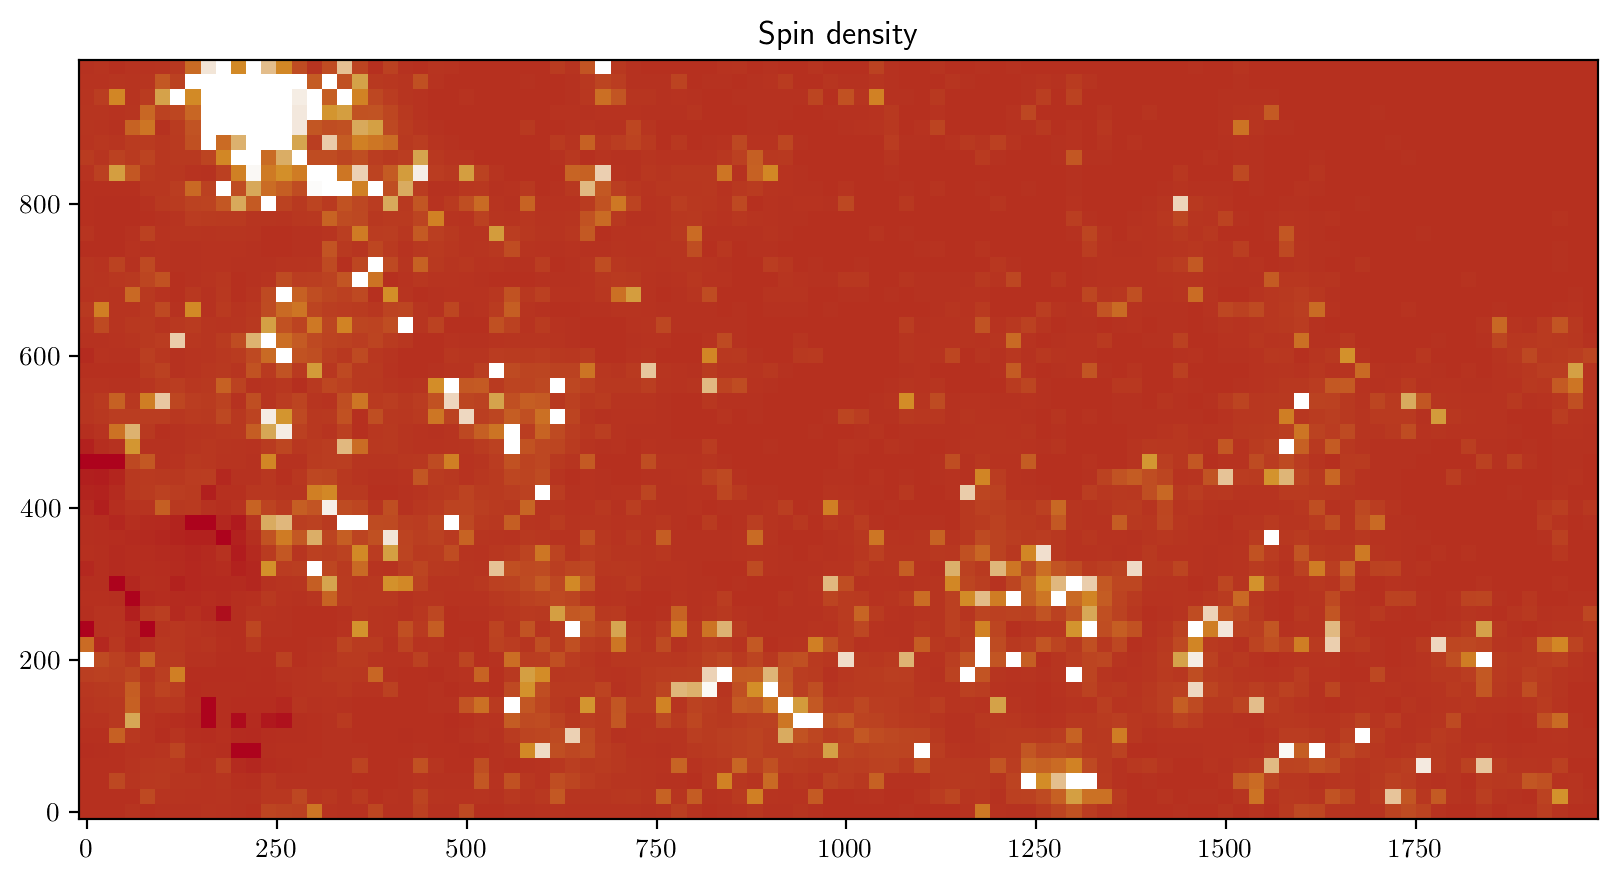

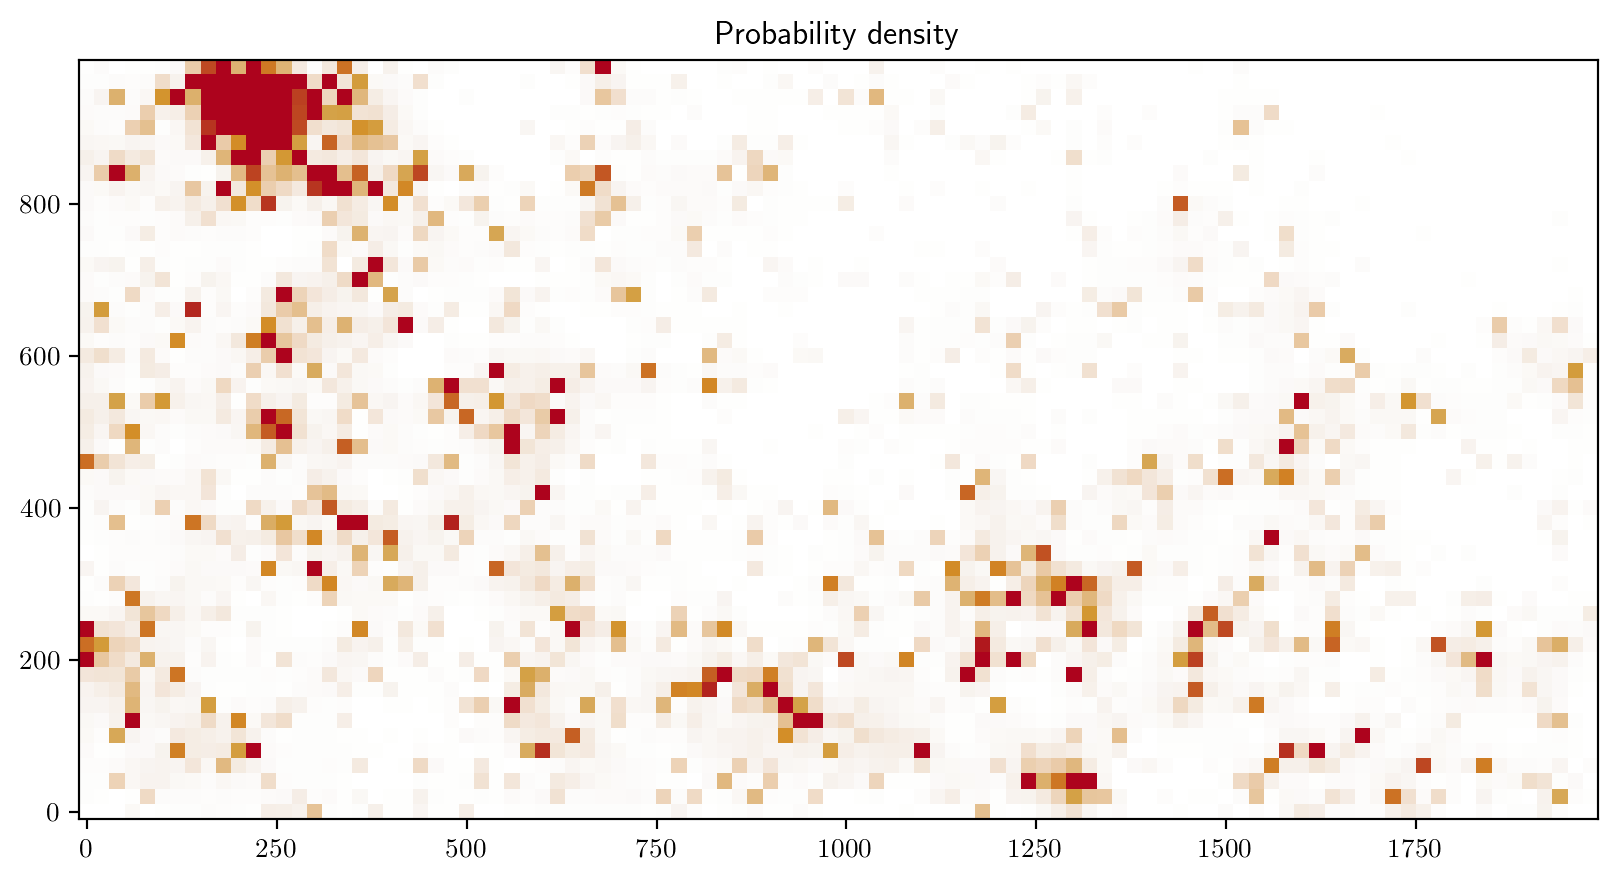

In [7]:
plot_prob_spin(.5)

1.0


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: The plotted data contains 0.68% of values overflowing upper limit 1.21886e-12 and 1.66% of values underflowing lower limit -9.17586e-12 
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: The plotted data contains 1.88% of values overflowing upper limit 445.85 


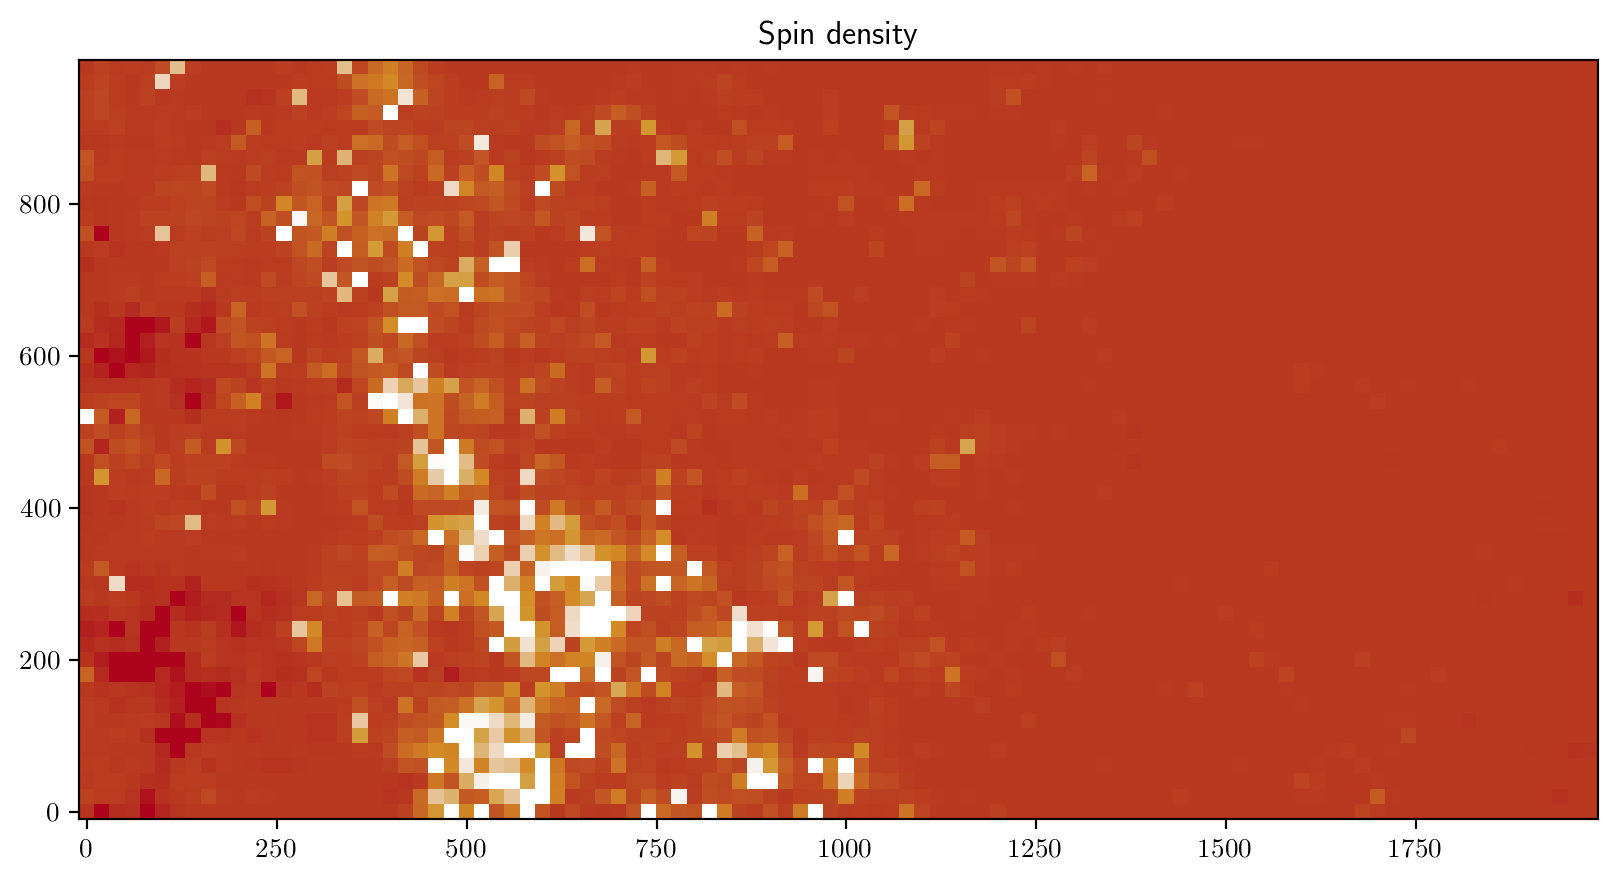

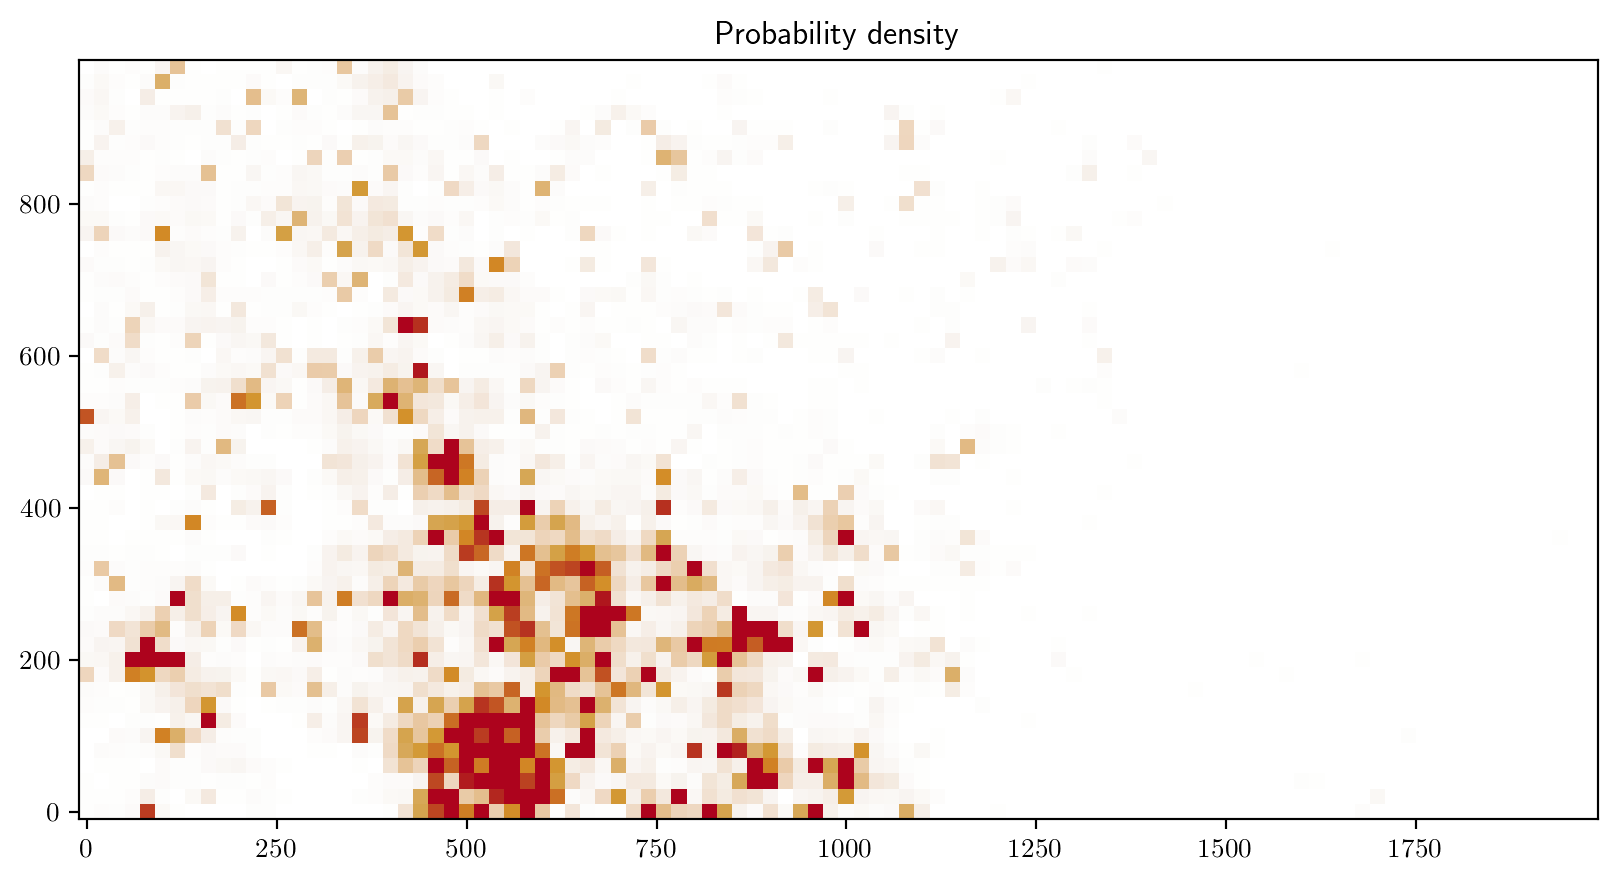

In [8]:
plot_prob_spin(1.0)

1.5


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: The plotted data contains 1.78% of values overflowing upper limit 2.67859e-12 and 1.74% of values underflowing lower limit -2.49557e-12 
/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: The plotted data contains 1.82% of values overflowing upper limit 14.0142 


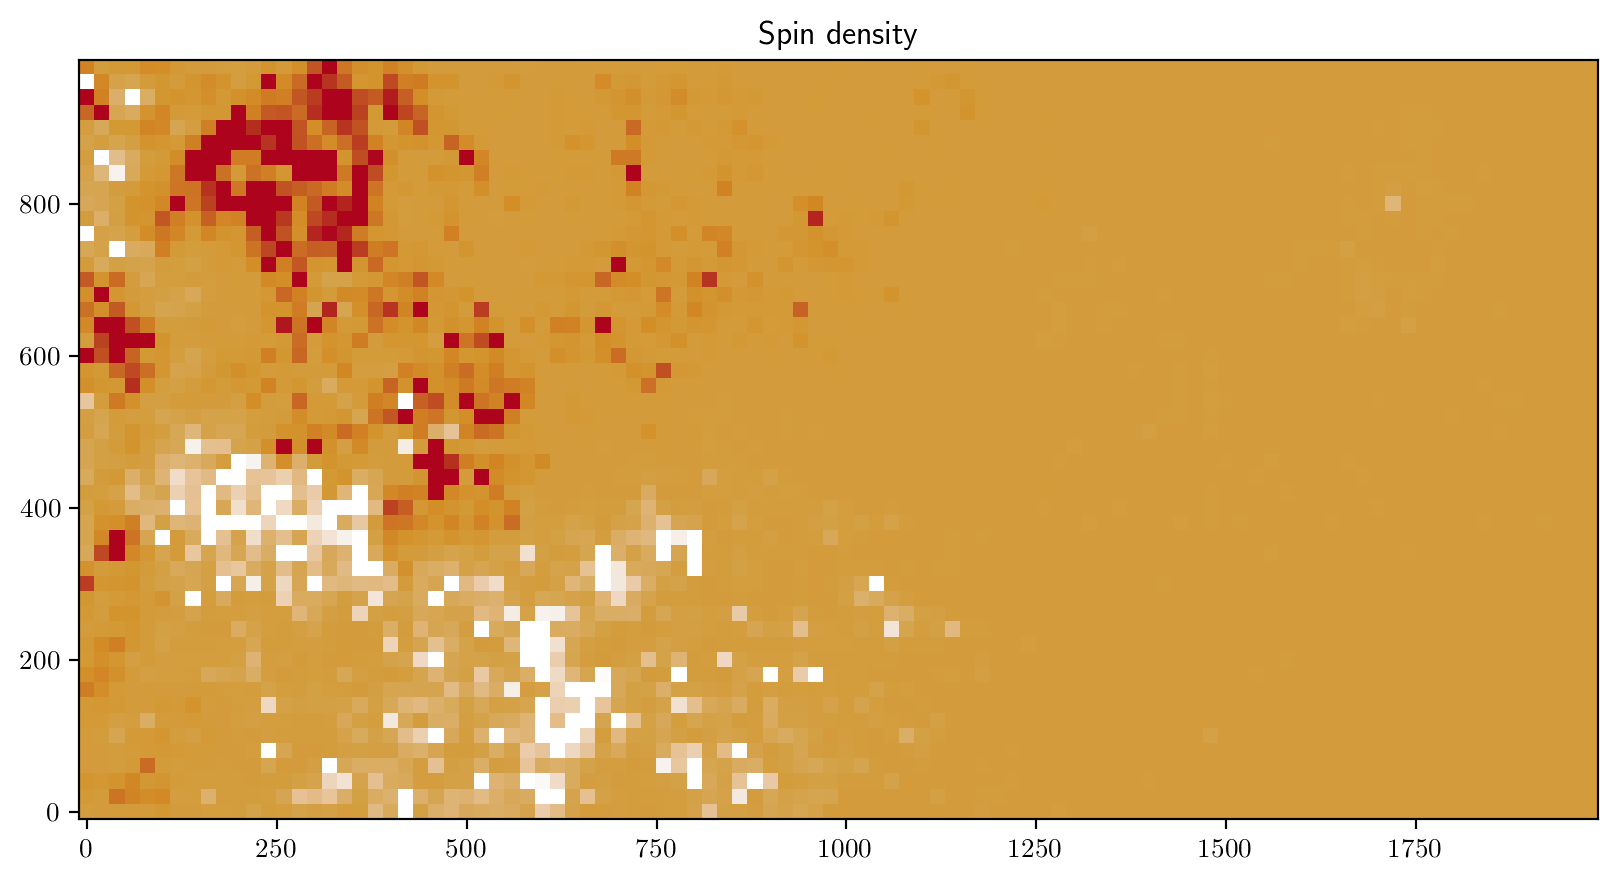

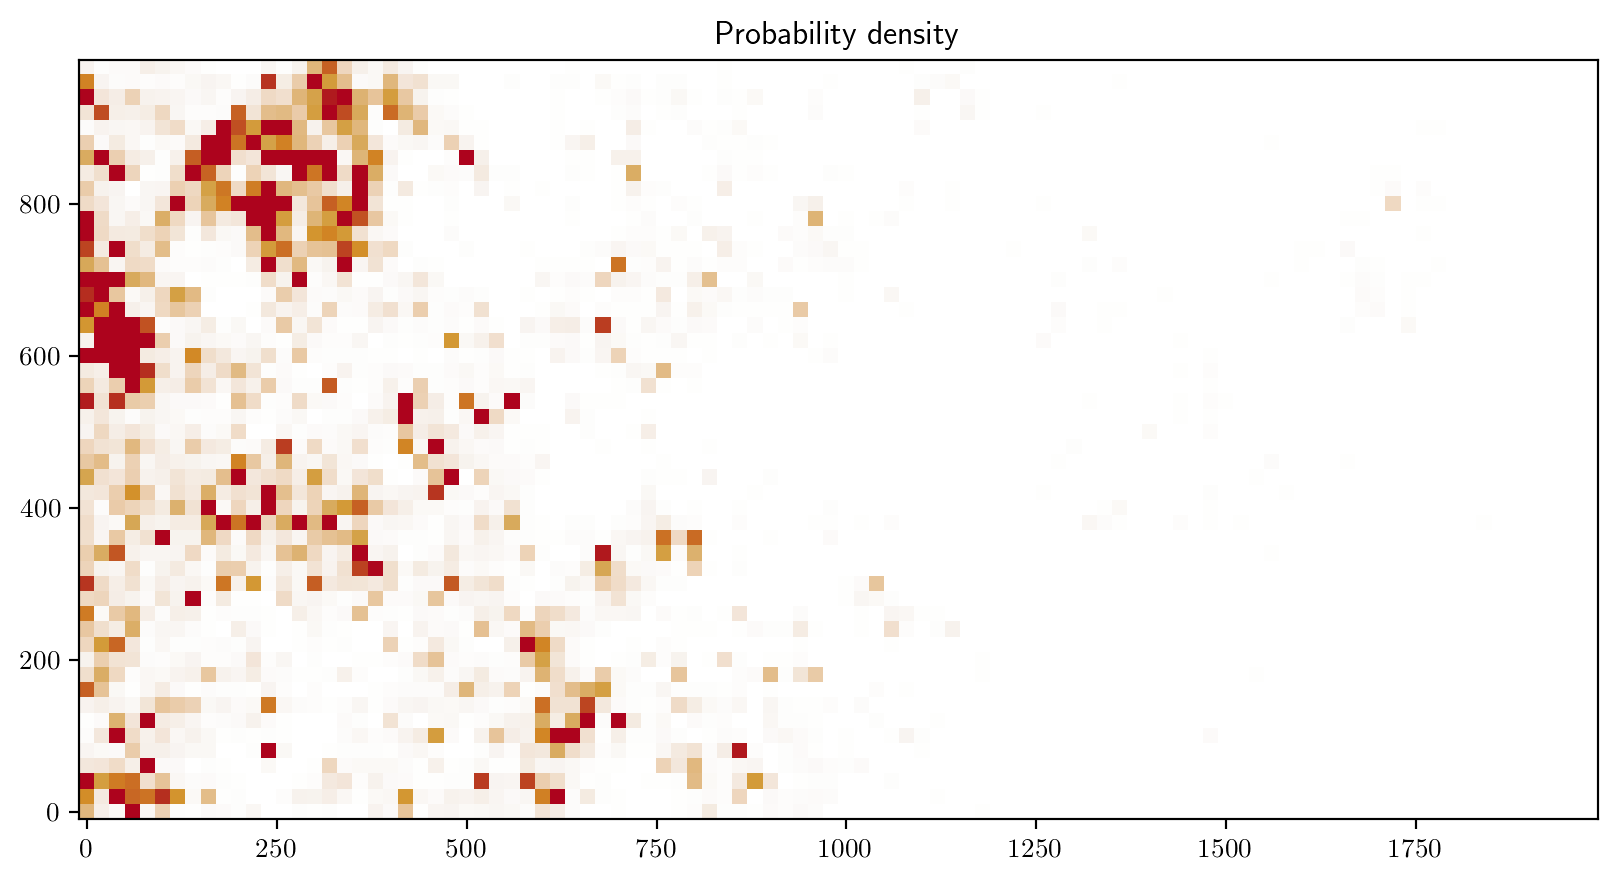

In [9]:
plot_prob_spin(1.5)

In [28]:
a = 10
res = []
for k in np.linspace(50*a, 250*a, 5):
  print(k)
  es, ws, gs = transmission_test(a=a, L=k, W=40*a, Wmax=2.0,
                                 npoints=20, Emax=0.0, nEpoints=1, plot=False)
  res.append((es, ws, gs))

500.0
1000.0
1500.0
2000.0
2500.0


<Figure size 1568x1176 with 0 Axes>

<Figure size 1568x1176 with 0 Axes>

<Figure size 1568x1176 with 0 Axes>

<Figure size 1568x1176 with 0 Axes>

<Figure size 1568x1176 with 0 Axes>

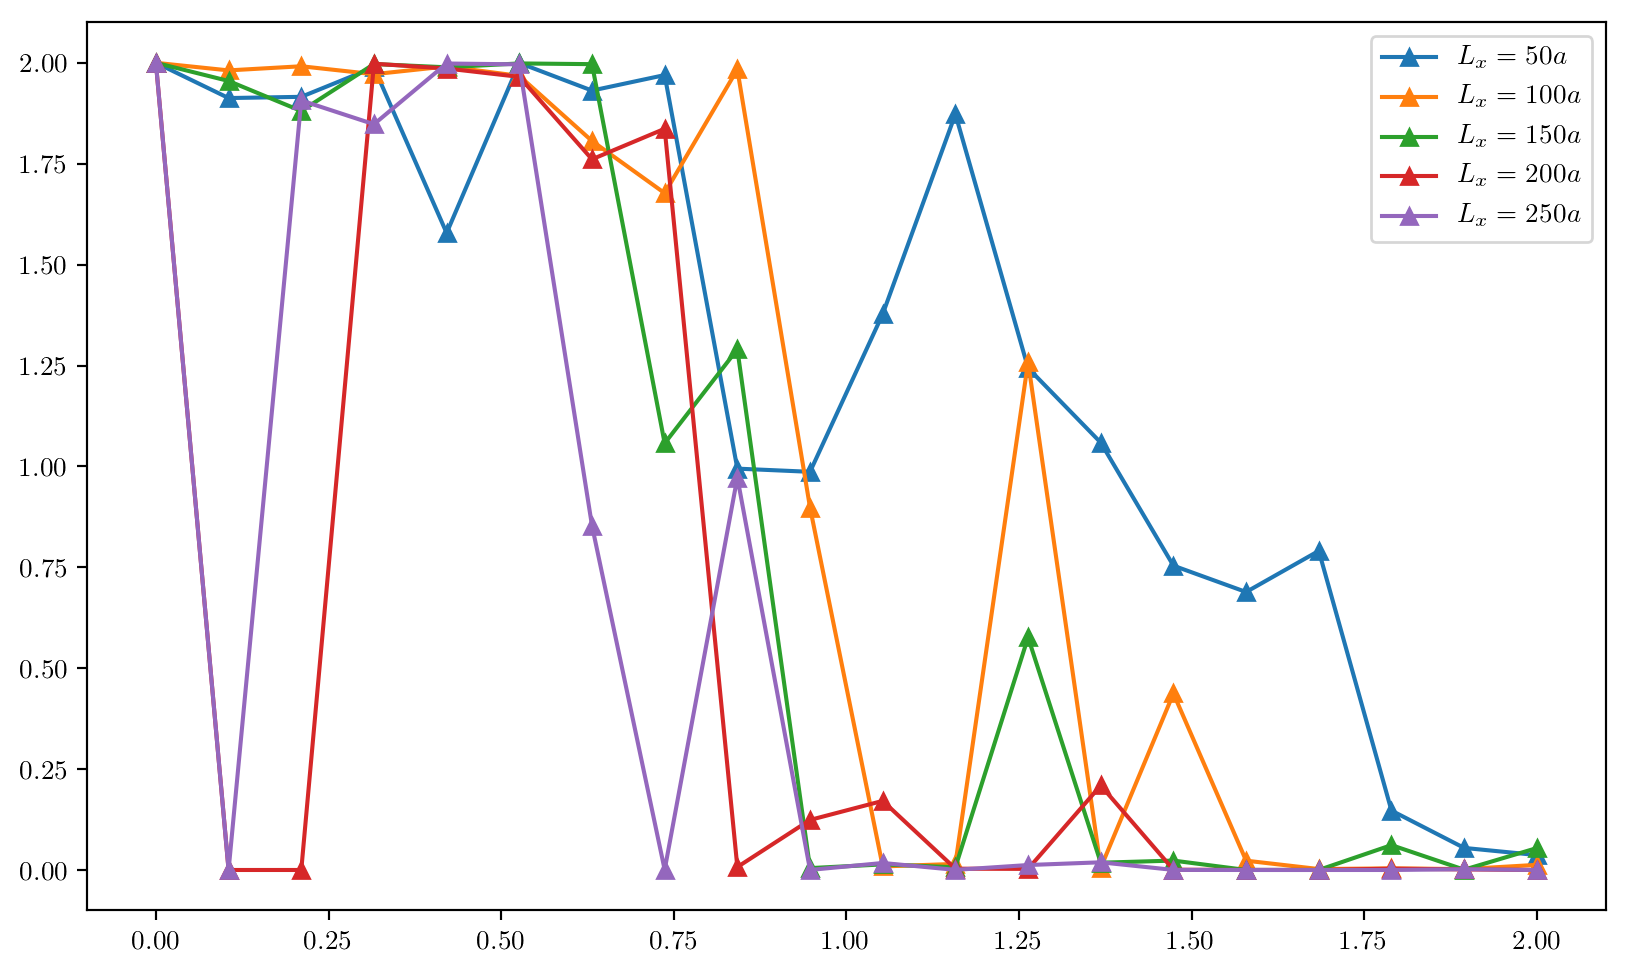

In [52]:
ks = np.linspace(50*a, 250*a, 5)
ws = res[0][1]
gs = [x[2]['1.0'] for x in res]

plt.figure(figsize=(10,6), dpi=196)
for k in range(len(ks)):
  plt.plot(ws, gs[k], '^-', label="$L_x={0}a$".format(int(ks[k]/a)))
plt.legend()
plt.savefig("transmission_dep_L_E=1dot0.png",dpi=196)

In [45]:
[x[2] for x in res][0]

{'0.0': [2.0000000000000004,
  1.9666529448085759,
  0.0,
  1.9863200840263138,
  1.9999627950952679,
  1.9993821485978085,
  1.9618513302010447,
  2.005844578824697,
  1.9735320990827063,
  1.081768811279908,
  1.7519904664250545,
  0.3843825732824916,
  1.838877569336227,
  0.614632440772104,
  1.103594647855487,
  1.2520289361450596,
  0.7852882293076628,
  0.45399843802024503,
  1.3738438274814735,
  0.2812663666815082],
 '0.25': [2.0000000000000004,
  0.0,
  0.0,
  1.9029202965986545,
  1.9954438933329883,
  1.9983748921398654,
  1.9995861344750778,
  2.003879449230496,
  1.3621842026212536,
  0.12003541115049544,
  2.0918099717481695,
  0.5266346313265969,
  0.49585799123276153,
  0.5997707421910553,
  0.7531894905589158,
  0.1827472567866816,
  0.08253469164629784,
  0.18653340815638897,
  0.48784388378171156,
  1.0632393593738807],
 '0.5': [2.0000000000000004,
  0.0,
  1.9485024839697158,
  1.9692769729573396,
  1.9951292853546205,
  1.9915790695358413,
  1.9999803099436126,
  

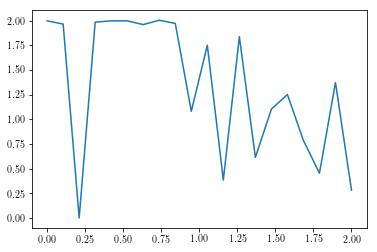

In [41]:
plt.plot(res[0][1], [0])